In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Machine Learning Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report

# Class Weight Computation
from sklearn.utils.class_weight import compute_class_weight

# Oversampling Techniques
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SMOTENC


# Import data

In [2]:
df_application = pd.read_csv('application_record.csv', encoding='utf8')
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
df_credit = pd.read_csv('credit_record.csv', encoding='utf8')
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# EDA
## Exploring
First, the metabase is investigated.

In [4]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [5]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


* It is shown that in the `df_application` DataFrame, only `Occupation type` has missing values. Thus, I prefer replacing the missing values with the string `Unknown` to droping the entries.
* The number of entries in `df_credit` is much greater than that in `df_application`. It MAY show that some customers do not have application records. However, to check this, I will next **explore duplicates**.

### Missing values

In [6]:
df_application['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

### Duplicates
First of all, I check if there were duplicated values in 2 DataFrames.

In [7]:
dup_application = df_application[df_application.duplicated(subset=['ID'], keep=False)].sort_values('ID')
dup_application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,Unknown,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,Unknown,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


In [8]:
dup_credit = df_credit[df_credit.duplicated(subset=['ID'], keep=False)].sort_values('ID')
dup_credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
22,5001712,-18,0
...,...,...,...
1048546,5150487,-1,C
1048545,5150487,0,C
1048573,5150487,-28,C
1048558,5150487,-13,C


There are a lot of duplicated values. Till now, I don't have any explanations for this problem.

Therefore, to merge data, I will **drop duplicated values**, just keeping 1 entry, let say the last entry.

In [9]:
df_application.drop_duplicates(subset=['ID'], keep='last', inplace=True)

In [10]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438510 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438510 non-null  int64  
 1   CODE_GENDER          438510 non-null  object 
 2   FLAG_OWN_CAR         438510 non-null  object 
 3   FLAG_OWN_REALTY      438510 non-null  object 
 4   CNT_CHILDREN         438510 non-null  int64  
 5   AMT_INCOME_TOTAL     438510 non-null  float64
 6   NAME_INCOME_TYPE     438510 non-null  object 
 7   NAME_EDUCATION_TYPE  438510 non-null  object 
 8   NAME_FAMILY_STATUS   438510 non-null  object 
 9   NAME_HOUSING_TYPE    438510 non-null  object 
 10  DAYS_BIRTH           438510 non-null  int64  
 11  DAYS_EMPLOYED        438510 non-null  int64  
 12  FLAG_MOBIL           438510 non-null  int64  
 13  FLAG_WORK_PHONE      438510 non-null  int64  
 14  FLAG_PHONE           438510 non-null  int64  
 15  FLAG_EMAIL           4

## Merging
Based on `ID`

In [11]:
df = df_credit.merge(df_application, how='right', left_on='ID', right_on='ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179768 entries, 0 to 1179767
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ID                   1179768 non-null  int64  
 1   MONTHS_BALANCE       777715 non-null   float64
 2   STATUS               777715 non-null   object 
 3   CODE_GENDER          1179768 non-null  object 
 4   FLAG_OWN_CAR         1179768 non-null  object 
 5   FLAG_OWN_REALTY      1179768 non-null  object 
 6   CNT_CHILDREN         1179768 non-null  int64  
 7   AMT_INCOME_TOTAL     1179768 non-null  float64
 8   NAME_INCOME_TYPE     1179768 non-null  object 
 9   NAME_EDUCATION_TYPE  1179768 non-null  object 
 10  NAME_FAMILY_STATUS   1179768 non-null  object 
 11  NAME_HOUSING_TYPE    1179768 non-null  object 
 12  DAYS_BIRTH           1179768 non-null  int64  
 13  DAYS_EMPLOYED        1179768 non-null  int64  
 14  FLAG_MOBIL           1179768 non-null  int64  
 15

## Transforming
There are some tasks should be done to clean data.
* `DAYS_BIRTH` should be converted into `AGE` (divided by 365)
* `DAYS_EMPLOYED` should be converted into `WORKING_YEARS` (divided by 365)
* `MONTHS_BALANCE`'s missing values are filled by the median

In [12]:
# Convert DAYS_BIRTH column to numeric type
df['DAYS_BIRTH'] = pd.to_numeric(df['DAYS_BIRTH'], errors='coerce')
df['AGE'] = (df['DAYS_BIRTH']*-1 / 365).astype(int)
df.drop('DAYS_BIRTH', axis=1, inplace=True)

In [13]:
# Convert DAYS_BIRTH column to numeric type
df['DAYS_EMPLOYED'] = pd.to_numeric(df['DAYS_EMPLOYED'], errors='coerce')
df['WORKING_YEARS'] = (df['DAYS_EMPLOYED']*-1 / 365).astype(int)
df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

In [14]:
# Fill missing values with median
df['MONTHS_BALANCE'] = df['MONTHS_BALANCE'].fillna(df['MONTHS_BALANCE'].median())

First of all, I consider the `STATUS` column, based on the quality (ascending order, the better, the greater number):
* 0: 1-29 days past due => Replace by 5
* 1: 30-59 days past due => Replace by 4
* 2: 60-89 days overdue => Replace by 3
* 3: 90-119 days overdue => Replace by 2
* 4: 120-149 days overdue => Replace by 1
* 5: Overdue or bad debts, write-offs for more than 150 days => Replace by 0
* C: paid off that month => Replace by 7
* X: No loan for the month => Replace by 6

In [15]:
status_score_map = {
    '0': 5,
    '1': 4,
    '2': 3,
    '3': 2,
    '4': 1,
    '5': 0,
    'C': 7,
    'X': 6
}

df['STATUS_SCORE'] = df['STATUS'].map(status_score_map)
df.drop(['STATUS'], inplace=True, axis=1)
df.dropna(inplace=True)

## Visualizing

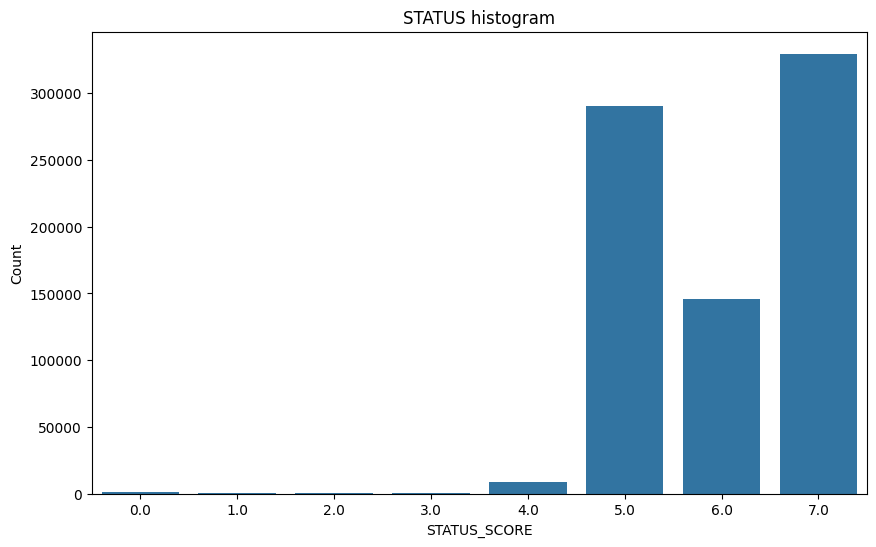

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='STATUS_SCORE', data=df)
plt.title('STATUS histogram')
plt.xlabel('STATUS_SCORE')
plt.ylabel('Count')
plt.show()

It is apparent that this dataset is unbalanced - most of the STATUS_SCORE classes are in high levels, while classes like 0,1,2,3,4 (which represent low credit ratings) are seldom. This may cause an issue later when training models. However, I will consider it later.

# Preprocessing & Feature Engineering
## Declare features and target variable

In [17]:
X = df.drop(['STATUS_SCORE', 'ID'], axis=1)
y = df['STATUS_SCORE']

## Split dataset into training and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Encoding categorical variables
Here I perform several encoding.

As categorical features are not in order, I perform `Binary Encoding` and `get_dummies`:
* If there are only 2 unique values, `Binary Encoding` is utilized
* Otherwise, `get_dummies`

(Some categorical features have already encoded, e.g., FLAG_EMAIL. Thus, I will exclude them from this step)

In [19]:
# Identify categorical and numerical features
already_encoded = ['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE', 'FLAG_EMAIL']

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'int32', 'float64']).columns.drop(already_encoded)
binary_columns = [col for col in categorical_columns if len(X[col].unique()) == 2]
categorical_columns = categorical_columns.drop(binary_columns)

In [20]:
X_train = pd.concat([X_train[numerical_columns]] + 
    [pd.get_dummies(X_train[col1], prefix=col1) for col1 in categorical_columns] +
    [pd.Series(LabelEncoder().fit_transform(X_train[col2]), name=col2, index=X_train.index) for col2 in binary_columns],
    axis=1)

X_test = pd.concat([X_test[numerical_columns]] + 
    [pd.get_dummies(X_test[col1], prefix=col1) for col1 in categorical_columns] +
    [pd.Series(LabelEncoder().fit_transform(X_test[col2]), name=col2, index=X_test.index) for col2 in binary_columns],
    axis=1)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 622172 entries, 71374 to 602234
Data columns (total 49 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MONTHS_BALANCE                                     622172 non-null  float64
 1   CNT_CHILDREN                                       622172 non-null  int64  
 2   AMT_INCOME_TOTAL                                   622172 non-null  float64
 3   CNT_FAM_MEMBERS                                    622172 non-null  float64
 4   AGE                                                622172 non-null  int32  
 5   WORKING_YEARS                                      622172 non-null  int32  
 6   NAME_INCOME_TYPE_Commercial associate              622172 non-null  bool   
 7   NAME_INCOME_TYPE_Pensioner                         622172 non-null  bool   
 8   NAME_INCOME_TYPE_State servant                     622172 non-null  bool   

## Feature Scaling

In [22]:
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Before training model, I want to glance at the relationships between them.

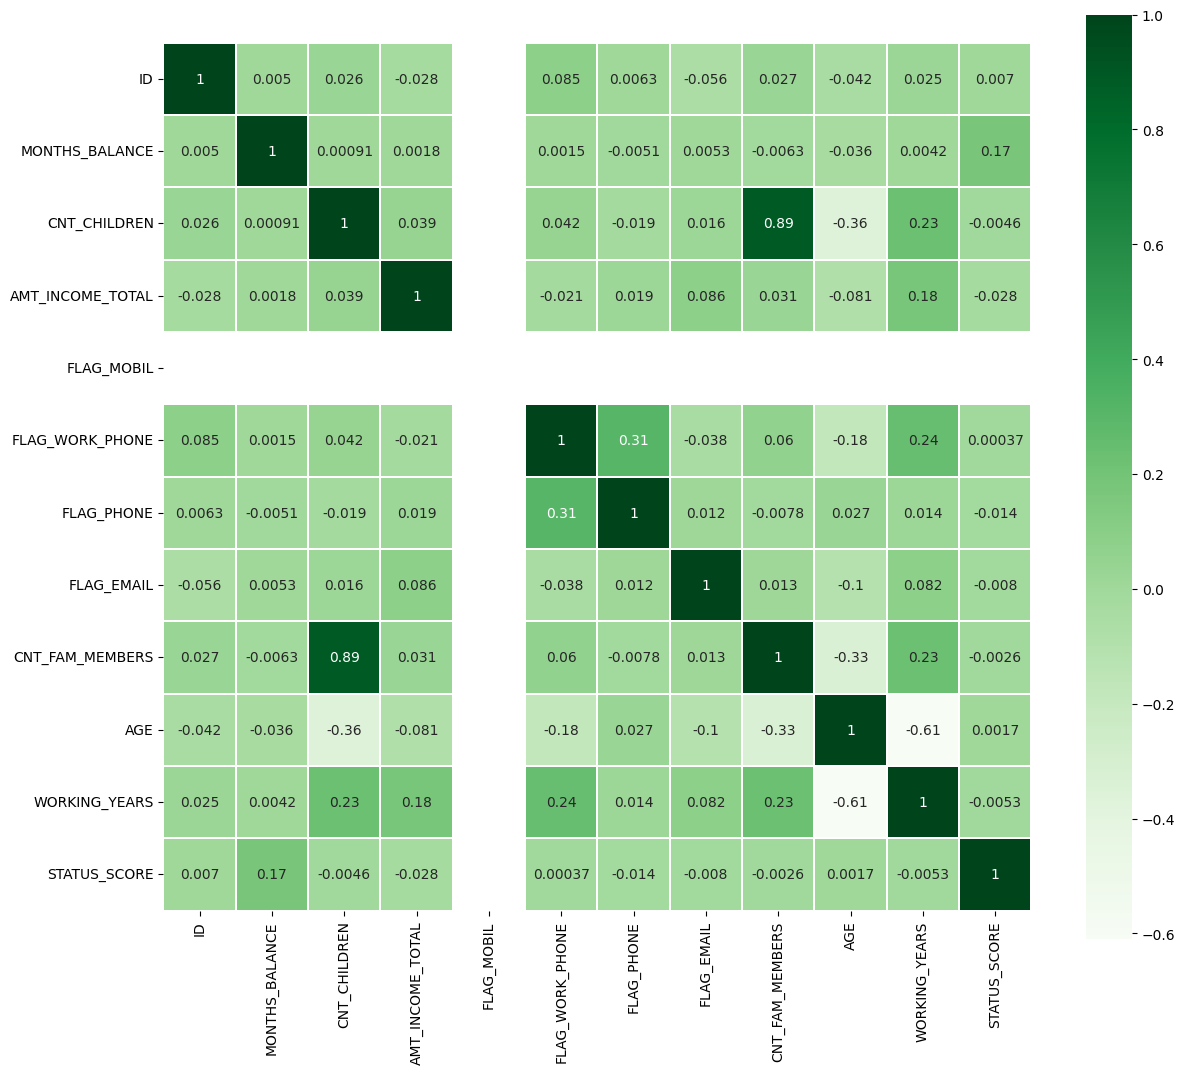

In [23]:
plt.figure(figsize=(14,12))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = plt.cm.Greens, linecolor='white', annot=True)
plt.show()

# Model training and evaluation
In this case, I will use RandomForest algorithm for the following reasons:
* RandomForest can efficiently handle multiclass classification tasks
* Fast training speed and high accuracy
* Compatible with large and complex datasets

Firstly, I train the model with default parameters
## 1. Train RF model with default parameters

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

### Evaluation

In [25]:
# Predict
y_pred = rf.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.608076223295166
              precision    recall  f1-score   support

         0.0       0.49      0.50      0.49       288
         1.0       0.08      0.07      0.08        41
         2.0       0.00      0.00      0.00        50
         3.0       0.10      0.07      0.09       160
         4.0       0.21      0.15      0.18      1720
         5.0       0.60      0.59      0.60     58135
         6.0       0.53      0.48      0.51     29075
         7.0       0.65      0.70      0.67     66074

    accuracy                           0.61    155543
   macro avg       0.33      0.32      0.33    155543
weighted avg       0.60      0.61      0.61    155543



## 2. Feature importance
I find the 20 most important features, then retrain the model with those features.

In [26]:
# Display feature importance levels
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("The 20 most important features:")
print(feature_importance.head(20))

The 20 most important features:
                                    feature  importance
0                            MONTHS_BALANCE    0.414418
4                                       AGE    0.127251
2                          AMT_INCOME_TOTAL    0.122673
5                             WORKING_YEARS    0.075599
48                          FLAG_OWN_REALTY    0.022579
3                           CNT_FAM_MEMBERS    0.020787
47                             FLAG_OWN_CAR    0.017542
1                              CNT_CHILDREN    0.016308
46                              CODE_GENDER    0.015707
10                 NAME_INCOME_TYPE_Working    0.011206
6     NAME_INCOME_TYPE_Commercial associate    0.010341
44                  OCCUPATION_TYPE_Unknown    0.009788
17               NAME_FAMILY_STATUS_Married    0.009365
35                 OCCUPATION_TYPE_Laborers    0.009288
30               OCCUPATION_TYPE_Core staff    0.007735
41              OCCUPATION_TYPE_Sales staff    0.007318
37              

In [27]:
# Retrain model
X_train_selected = X_train[feature_importance.head(20)['feature']]
X_test_selected = X_test[feature_importance.head(20)['feature']]
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train)

RandomForestClassifier()

In [28]:
# Predict
y_pred = rf.predict(X_test_selected)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.6059417652996277
              precision    recall  f1-score   support

         0.0       0.49      0.49      0.49       288
         1.0       0.08      0.07      0.08        41
         2.0       0.00      0.00      0.00        50
         3.0       0.08      0.06      0.07       160
         4.0       0.22      0.15      0.18      1720
         5.0       0.60      0.59      0.59     58135
         6.0       0.53      0.48      0.50     29075
         7.0       0.65      0.69      0.67     66074

    accuracy                           0.61    155543
   macro avg       0.33      0.32      0.32    155543
weighted avg       0.60      0.61      0.60    155543



The model still perform poorly, with pretty low accuracy score, precision, F1, recall. There is no improvement before and after apply Feature importance.

Possible problems:
* Imbalanced dataset
* Inappropriate parameters

I will solve the imbalance in the dataset.
## 3. Imbalance resampling
As mentioned above, this dataset is unbalanced. Therefore, I will apply `SMOTE-NC` to handle this imbalance.

Firstly, I will calculate the weights for each class.

In [29]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0.0: 62.769572235673934, 1.0: 449.54624277456645, 2.0: 329.54025423728814, 3.0: 121.32839313572543, 4.0: 11.067525259712538, 5.0: 0.33447374193076695, 6.0: 0.6654245989304813, 7.0: 0.2951905777683309}


As can be shown, the weights are very unbalanced. Now I will apply SMOTE-NC, then retrain the model

In [32]:
# SMOTE
smote = SMOTENC(categorical_features=list(range(6, 20)))
X_train_smote_selected, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Train model
rf = RandomForestClassifier(class_weight=class_weight_dict)
rf.fit(X_train_smote_selected, y_train_smote)

# Predict
y_pred = rf.predict(X_test_selected)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.5766186842223694
              precision    recall  f1-score   support

         0.0       0.34      0.53      0.41       288
         1.0       0.04      0.10      0.05        41
         2.0       0.02      0.06      0.03        50
         3.0       0.05      0.11      0.07       160
         4.0       0.11      0.25      0.15      1720
         5.0       0.60      0.56      0.58     58135
         6.0       0.45      0.56      0.50     29075
         7.0       0.67      0.61      0.64     66074

    accuracy                           0.58    155543
   macro avg       0.28      0.35      0.30    155543
weighted avg       0.59      0.58      0.58    155543



The accuracy is lower than that before resampling. However, I suppose that resampling is crucial for unbalanced datasets (like in this case). Therefore, I will use the resampled dataset for hyperparameter tuning to enhance the model.

## 4. Hyperparameter tuning
I use GridSearchCV for tuning the following hyperparameters:
* `n_estimators`
* `max_depth`
* `min_samples_split`
* `max_features` 
* `bootstrap`

In [33]:
param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20], 
    'min_samples_split': [10, 20], 
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [34]:
# Set up GridSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf
    , param_distributions=param_grid
    , n_iter=10
    , cv=5
    , random_state=42
)

random_search.fit(X_train_smote_selected, y_train_smote)

# Evaluation
y_pred = random_search.best_estimator_.predict(X_test_selected)

# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

## 5. Voting ensemble method
Here I use RandomForest, SVM, XGBoost and LightGBM for Voting.

In [ ]:
# Set up a set of estimators
estimators = []


# Define estimators
rf = RandomForestClassifier(n_estimators = 50
                              , min_samples_split = 20
                              , max_features = None
                              , max_depth = None
                              , bootstrap = True ) # from hyperparameter tuning
estimators.append(('RandomForest', rf))

svm_clf = SVC(gamma='scale')
estimators.append(('SVM', svm_clf))

xgboost = XGBClassifier()
estimators.append(('XGBoost', xgboost))

lgbm = LGBMClassifier()
estimators.append(('LightGBM', lgbm))


# Train voting algo
voting = VotingClassifier(estimators=estimators)
voting.fit(X_train_smote_selected, y_train_smote)

# Evaluation
y_pred = voting.predict(X_test_selected)

# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))